In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import shap

In [ ]:
# Ignoring warnings (many warnings come from the FairLearn package)
import warnings
warnings.filterwarnings('ignore')

#### Reading in the data and getting an overview

In [ ]:
# Starting with 35k observations that have NA values filled from KNN imputation
df = pd.read_csv('na_filled_df.csv').sample(n=35000, random_state=2025)
df.shape

(35000, 21)

****

### Formatting the data

In [ ]:
# Selecting the x variables
columns_to_select = ['action_taken', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'preapproval', 'property_value',
                     'loan_purpose', 'lien_status', 'reverse_mortgage', 'open-end_line_of_credit', 'business_or_commercial_purpose', 'loan_amount', 'loan_to_value_ratio',
                     'loan_term', 'negative_amortization', 'occupancy_type', 'income', 'debt_to_income_ratio']
df0 = df.copy()
df0 = df0[columns_to_select]
df0.shape

(35000, 18)

In [ ]:
# Finding categorical variables
string_columns = df0.select_dtypes(include=['object']).columns
string_df = df0[string_columns]
print(string_columns)

Index(['conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category'],
      dtype='object')


In [ ]:
# Seeing how many unique values each category has
unique_counts = {}

for column in string_columns:
    unique_counts[column] = df[column].nunique()

unique_counts

{'conforming_loan_limit': 3,
 'derived_loan_product_type': 6,
 'derived_dwelling_category': 3}

In [ ]:
# Making sure these are strings and not mixed data types
df['applicant_sex'] = df['applicant_sex'].astype(str)
df['applicant_age_above_62'] = df['applicant_age_above_62'].astype(str)
df['derived_race'] = df['derived_race'].astype(str)
df_dummies = pd.get_dummies(df0, columns=string_columns, drop_first=True)
df_dummies.shape

(35000, 24)

****

## Building a random forest model

In [ ]:
# Splitting the data
y = df_dummies['action_taken']
X = df_dummies.drop(columns='action_taken')
# Inlcuding the sensitive features also to use later in Fairlearn
sensitive_features_data = df[['applicant_sex', 'applicant_age_above_62', 'derived_race']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2023)
sensitive_features_train, sensitive_features_test = train_test_split(sensitive_features_data, test_size=0.25, random_state=2023)

In [ ]:
# Building the random forest model
np.random.seed(2023)
rf0 = RandomForestClassifier(n_estimators=100, random_state=2023)
rf0.fit(X_train, y_train)

# Generating predictions and displaying the confusion matrix
y_pred = rf0.predict(X_test)

In [ ]:
# Saving predictions to a csv file, making sure to keep sensitive features

# Create a DataFrame from the predictions, using X_test's index
predictions_df = pd.DataFrame(y_pred, index=X_test.index, columns=['predictions'])

# Merge predictions with actual values
rf_v1_test_predictions = pd.concat([predictions_df, y_test], axis=1)

# Merge the combined_df with sensitive_features_test
rf_v1_test_predictions = rf_v1_test_predictions.merge(sensitive_features_test, left_index=True, right_index=True)
rf_v1_test_predictions = rf_v1_test_predictions.merge(X_test, left_index=True, right_index=True)

rf_v1_test_predictions.to_csv('rf_v1_test_predictions.csv')

# final_df now contains predictions, actuals, and sensitive features, all aligned with the original index


In [ ]:
# Manually defining some metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Define False Positive Rate
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

# Define False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Define Selection Rate
def selection_rate(y_true, y_pred):
    return sum(y_pred) / len(y_pred)

# Define Count (this is simply the length of y_pred)
def count(y_true, y_pred):
    return len(y_pred)

Accuracy: 0.7830
Precision: 0.7968
Recall: 0.9152
F1 Score: 0.8519
False positive rate: 0.5005
False negative rate: 0.0848
Selection rate: 0.7833
Count: 8750.0000
Confusion Matrix:


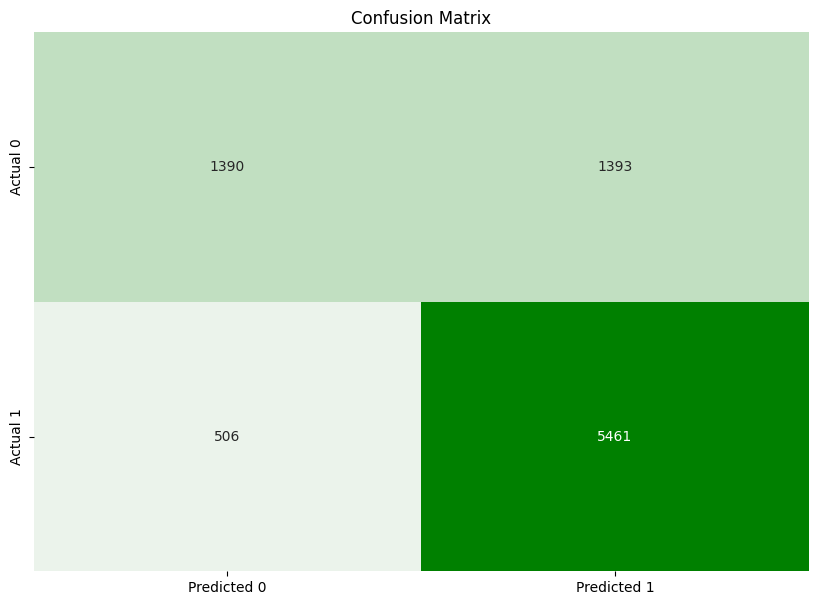

In [ ]:
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)
fnr =  false_negative_rate(y_test, y_pred)
sr = selection_rate(y_test, y_pred)
total = count(y_test, y_pred)

# Printing metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"False positive rate: {fpr:.4f}")
print(f"False negative rate: {fnr:.4f}")
print(f"Selection rate: {sr:.4f}")
print(f"Count: {total:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
# Create a custom color map
cmap = sns.light_palette("green", as_cmap=True)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.show()

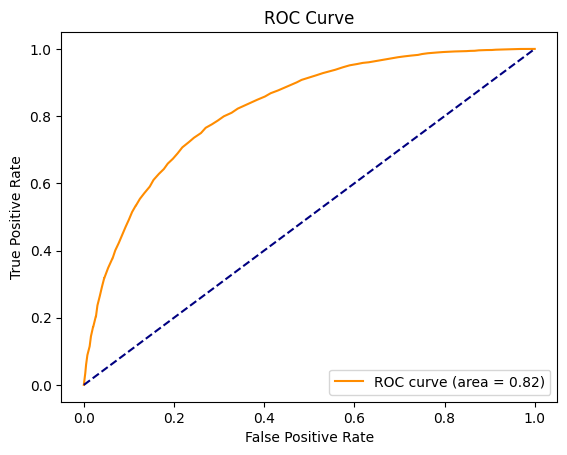

In [ ]:
# Plotting the ROC curve
y_prob = rf0.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
importances = rf0.feature_importances_.round(3)
sorted_indices = np.argsort(importances)[::-1]
sorted_features = [X.columns[idx] for idx in sorted_indices]

sorted_features_with_importance = []
for i, idx in enumerate(sorted_indices):
    feature_name = X.columns[idx]
    importance_value = importances[idx]
    print(f"{i + 1}. {feature_name} ({importance_value})")
    sorted_features_with_importance.append((feature_name, importance_value))

1. loan_to_value_ratio (0.205)
2. income (0.173)
3. property_value (0.159)
4. loan_amount (0.134)
5. debt_to_income_ratio (0.134)
6. loan_purpose (0.055)
7. loan_term (0.045)
8. derived_loan_product_type_VA:First Lien (0.013)
9. derived_loan_product_type_FHA:First Lien (0.013)
10. occupancy_type (0.012)
11. open-end_line_of_credit (0.011)
12. derived_dwelling_category_Single Family (1-4 Units):Manufactured (0.007)
13. business_or_commercial_purpose (0.006)
14. derived_dwelling_category_Single Family (1-4 Units):Site-Built (0.006)
15. preapproval (0.006)
16. lien_status (0.005)
17. derived_loan_product_type_Conventional:Subordinate Lien (0.004)
18. conforming_loan_limit_NC (0.003)
19. reverse_mortgage (0.003)
20. negative_amortization (0.002)
21. derived_loan_product_type_FSA/RHS:First Lien (0.002)
22. conforming_loan_limit_U (0.001)
23. derived_loan_product_type_FHA:Subordinate Lien (0.0)


### Shapley values

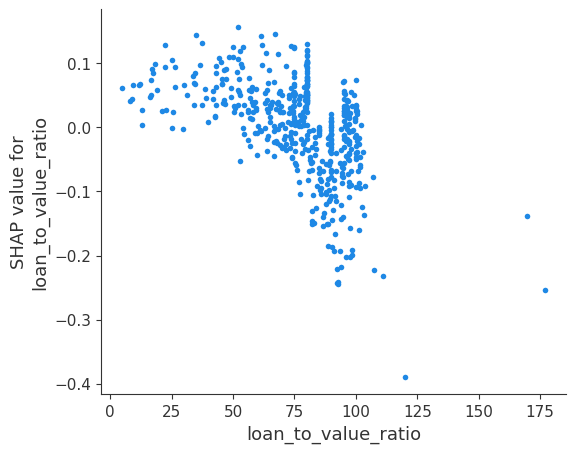

In [ ]:
# Using the shap package
import shap

explainer = shap.TreeExplainer(rf0)
shap_values = explainer.shap_values(X_test[0:500])

# Dependence plot
# Looking at just LTV ratio right now
feature_to_plot = 'loan_to_value_ratio'
shap.dependence_plot(feature_to_plot, shap_values[1], X_test[0:500], interaction_index=None)

In [ ]:
# Force plot
shap.initjs() # initialize java script
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0])

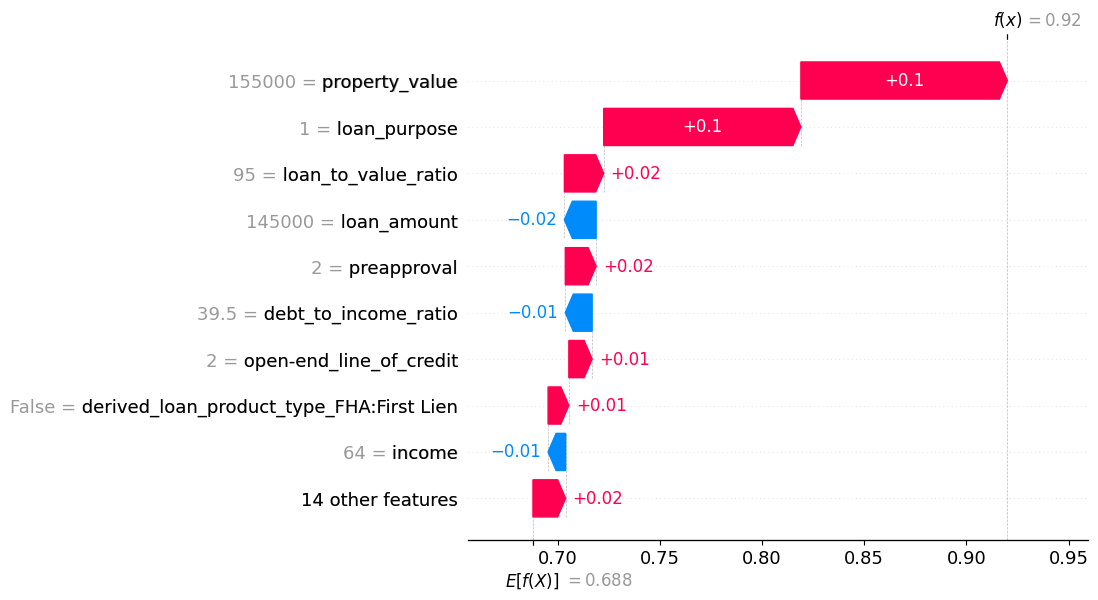

In [ ]:
# Waterfall plot
explanation = shap.Explanation(shap_values[1][0], base_values=explainer.expected_value[1], data=X_test.iloc[0])

# Waterfall plot for the first prediction
shap.waterfall_plot(explanation)

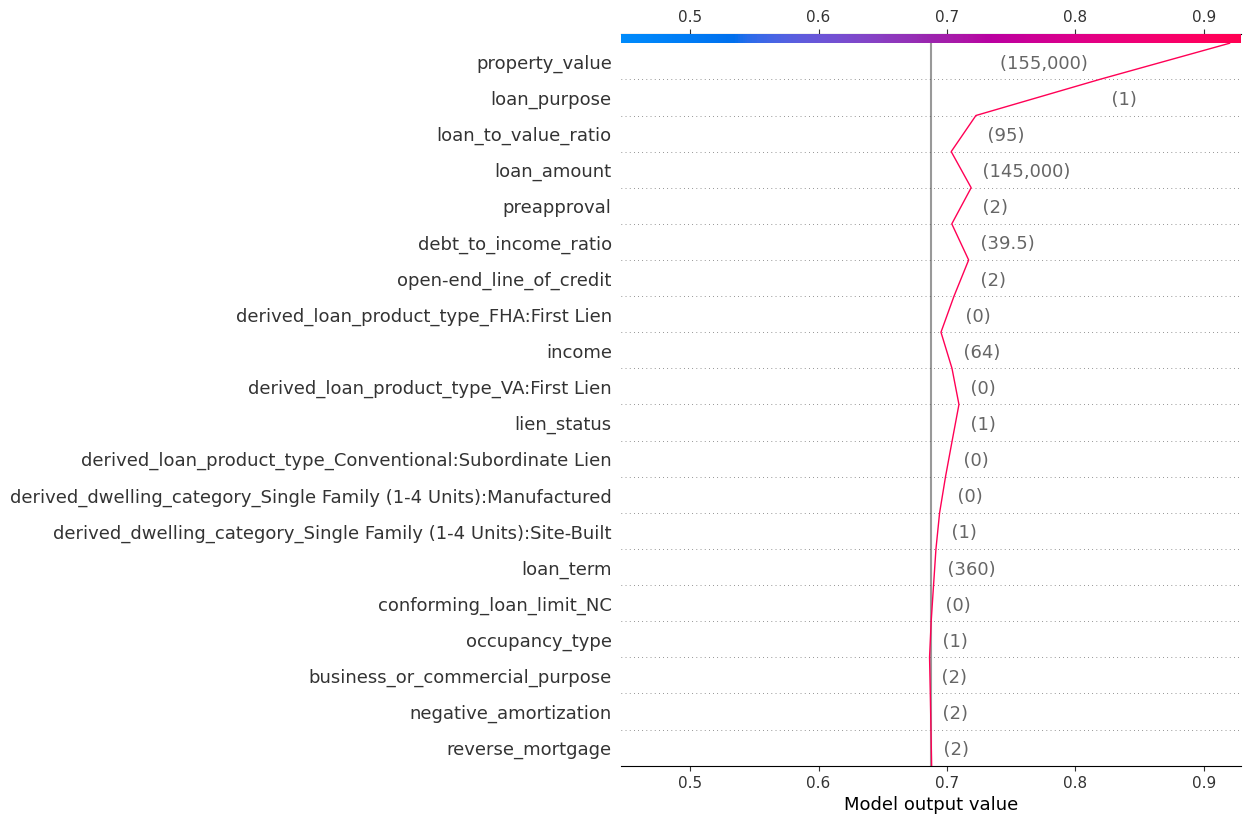

In [ ]:
# Decision plot
shap.decision_plot(explainer.expected_value[1], shap_values[1][0], X_test[0:500])

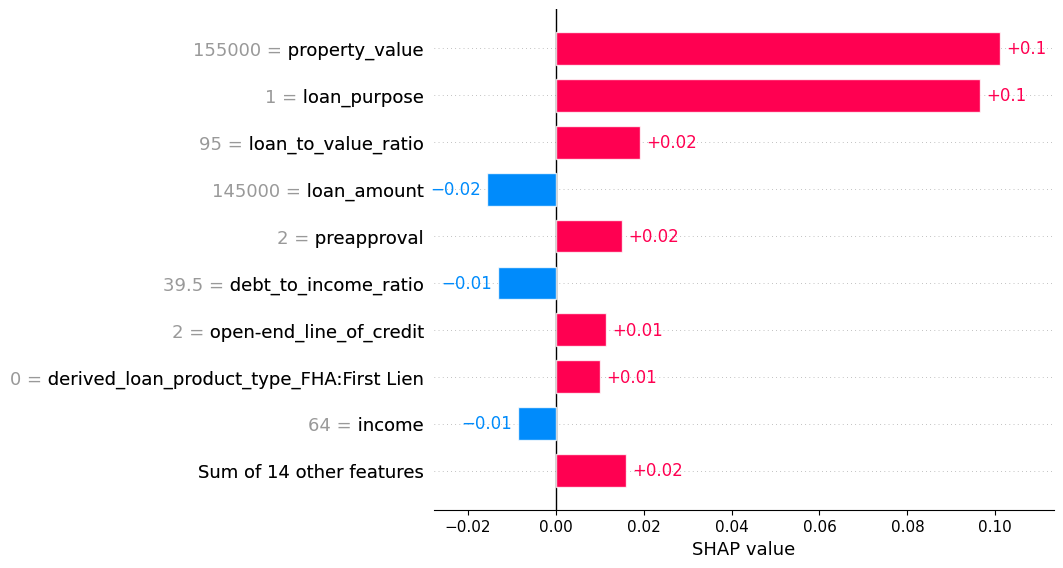

In [ ]:
# Bar plot
shap.plots.bar(explanation)

****

## Looking into metrics with Microsoft Fairlearn

In [ ]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate

In [ ]:
# Accuracy by race
mf = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])
print(mf.overall)
mf.by_group

0.7829714285714285


derived_race
2 or more minority races                     0.756757
American Indian or Alaska Native             0.805556
Asian                                        0.784897
Black or African American                    0.745063
Native Hawaiian or Other Pacific Islander    0.708333
Race Not Available                           0.797537
White                                        0.782339
Name: accuracy_score, dtype: float64

In [ ]:
# Selection rate is the percentage of the population that is labeled '1'
sr = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])
print(sr.overall)
sr.by_group

0.7833142857142857


derived_race
2 or more minority races                     0.805405
American Indian or Alaska Native             0.694444
Asian                                        0.798627
Black or African American                    0.667864
Native Hawaiian or Other Pacific Islander    0.541667
Race Not Available                           0.820690
White                                        0.780879
Name: selection_rate, dtype: float64

### Applicant sex

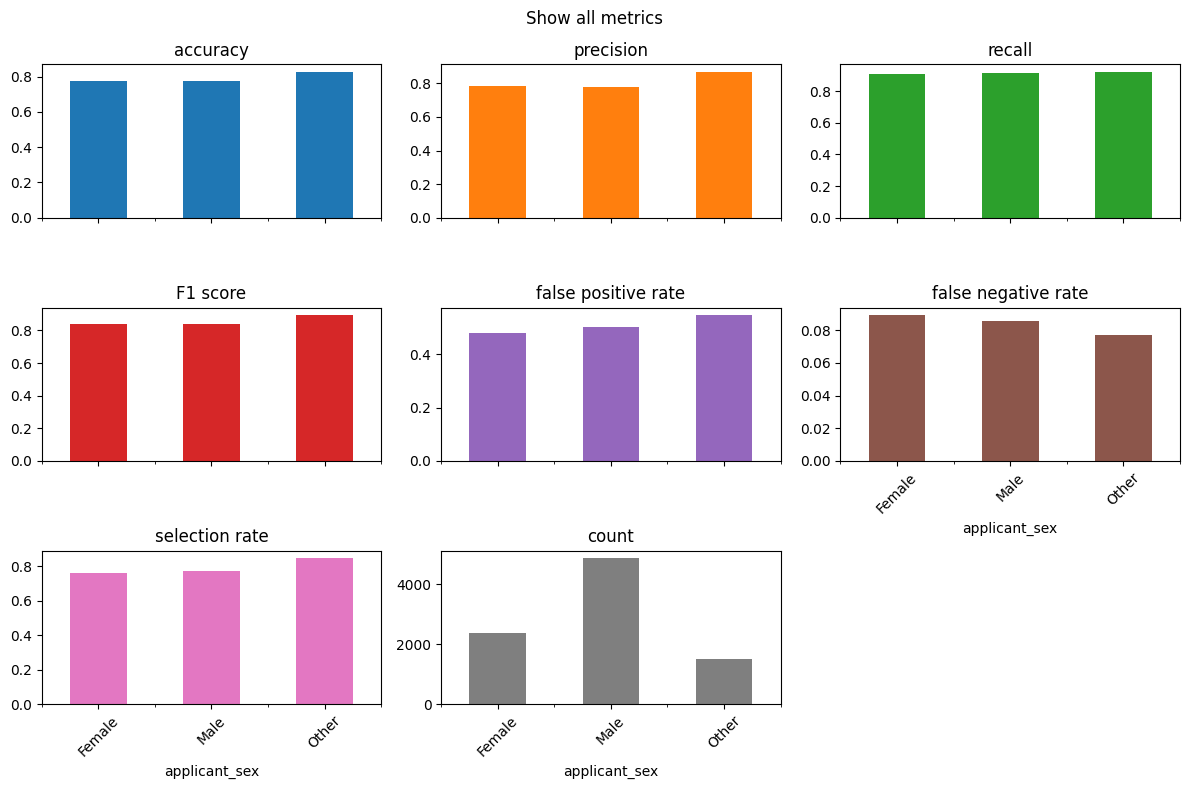

In [ ]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "F1 score": f1_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['applicant_sex'])


axes = metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics"
)

# Iterate over each subplot
for ax in axes.flatten():
    # Rotate the x-axis labels in each subplot
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Same info as the graph above but in table format

# Create a rounded table
rounded_table = metric_frame.by_group.round(3)

# Display the table
print(rounded_table)

               accuracy  precision  recall  F1 score  false positive rate  \
applicant_sex                                                               
Female            0.775      0.782   0.911     0.841                0.481   
Male              0.773      0.780   0.915     0.842                0.502   
Other             0.828      0.869   0.923     0.895                0.548   

               false negative rate  selection rate   count  
applicant_sex                                               
Female                       0.089           0.762  2380.0  
Male                         0.085           0.774  4878.0  
Other                        0.077           0.847  1492.0  


### Applicant race

array([[<Axes: title={'center': 'accuracy'}, xlabel='derived_race'>,
        <Axes: title={'center': 'precision'}, xlabel='derived_race'>,
        <Axes: title={'center': 'recall'}, xlabel='derived_race'>],
       [<Axes: title={'center': 'F1 score'}, xlabel='derived_race'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='derived_race'>,
        <Axes: title={'center': 'false negative rate'}, xlabel='derived_race'>],
       [<Axes: title={'center': 'selection rate'}, xlabel='derived_race'>,
        <Axes: title={'center': 'count'}, xlabel='derived_race'>,
        <Axes: xlabel='derived_race'>]], dtype=object)

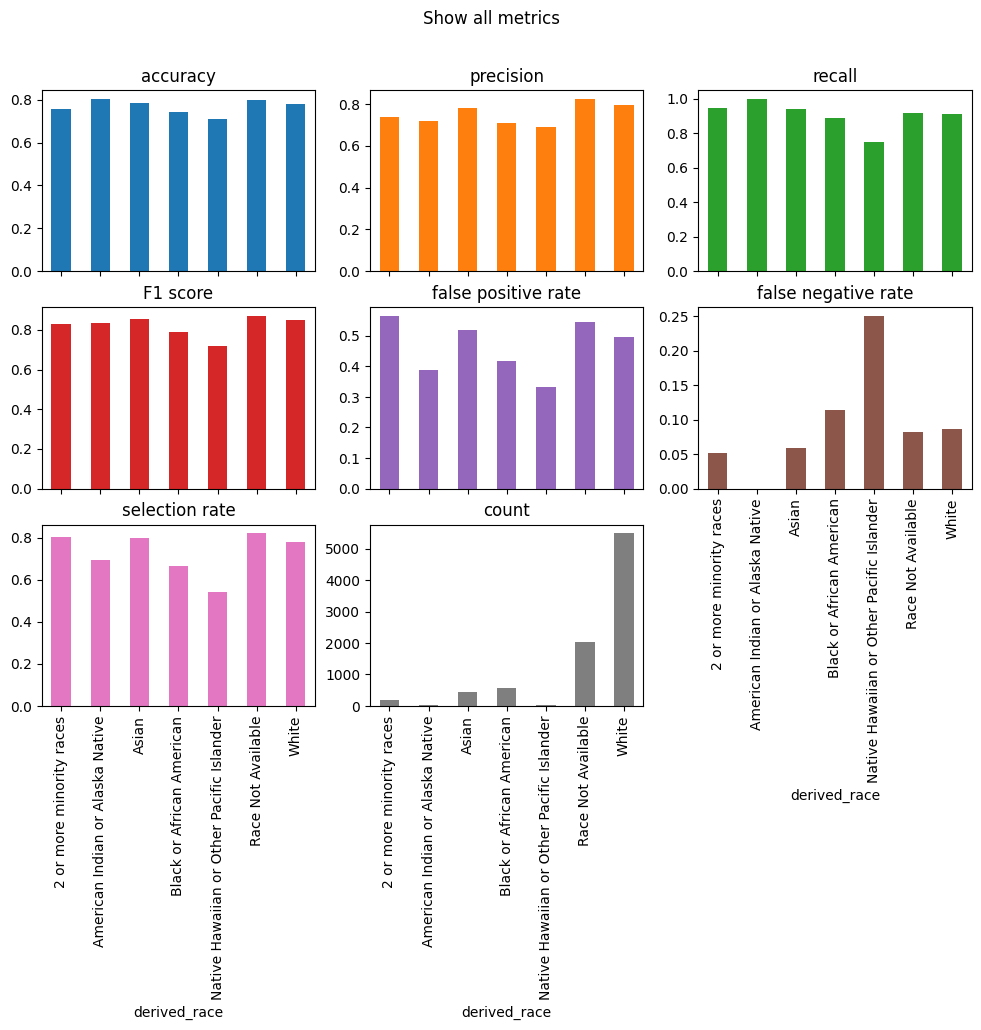

In [ ]:
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [ ]:
# Same info as the graph above but in table format

# Create a rounded table
rounded_table = metric_frame.by_group.round(3)

# Display the table
print(rounded_table)

                                           accuracy  precision  recall  \
derived_race                                                             
2 or more minority races                      0.757      0.738   0.948   
American Indian or Alaska Native              0.806      0.720   1.000   
Asian                                         0.785      0.779   0.941   
Black or African American                     0.745      0.710   0.886   
Native Hawaiian or Other Pacific Islander     0.708      0.692   0.750   
Race Not Available                            0.798      0.827   0.919   
White                                         0.782      0.797   0.913   

                                           F1 score  false positive rate  \
derived_race                                                               
2 or more minority races                      0.830                0.565   
American Indian or Alaska Native              0.837                0.389   
Asian                        

### Applicant age above 62

array([[<Axes: title={'center': 'accuracy'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'precision'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'recall'}, xlabel='applicant_age_above_62'>],
       [<Axes: title={'center': 'F1 score'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'false negative rate'}, xlabel='applicant_age_above_62'>],
       [<Axes: title={'center': 'selection rate'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'count'}, xlabel='applicant_age_above_62'>,
        <Axes: xlabel='applicant_age_above_62'>]], dtype=object)

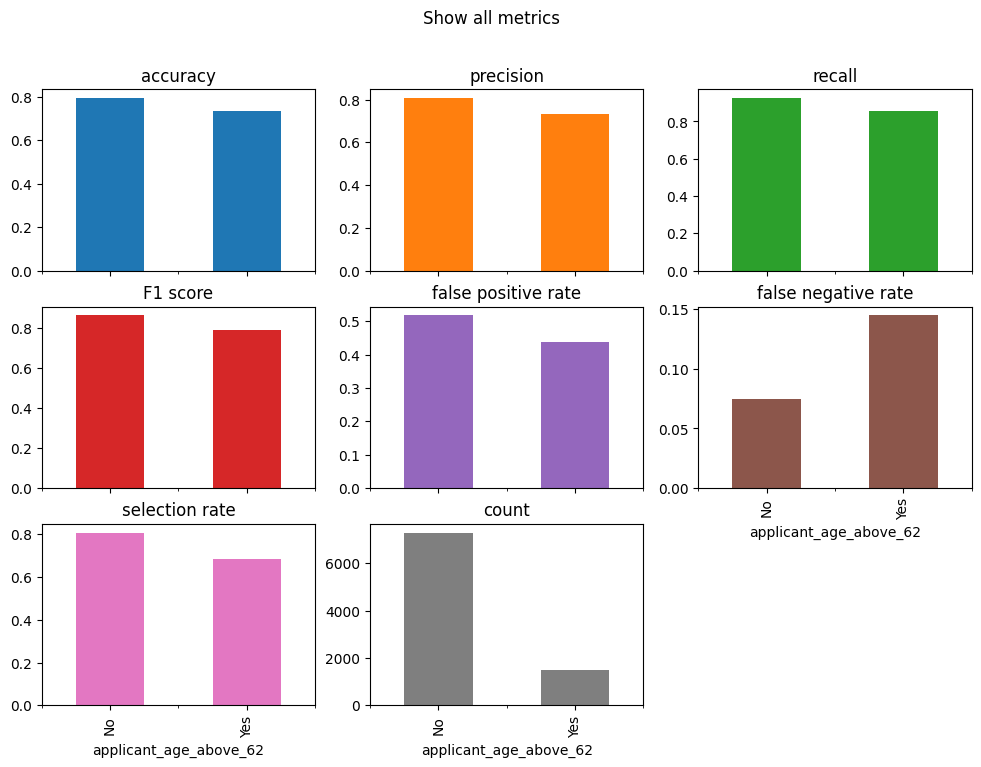

In [ ]:
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test,
    y_pred=y_pred, sensitive_features=sensitive_features_test['applicant_age_above_62'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [ ]:
# Same info as the graph above but in table format

# Create a rounded table
rounded_table = metric_frame.by_group.round(3)

# Display the table
print(rounded_table)

                        accuracy  precision  recall  F1 score  \
applicant_age_above_62                                          
No                         0.793      0.807   0.925     0.862   
Yes                        0.734      0.735   0.855     0.791   

                        false positive rate  false negative rate  \
applicant_age_above_62                                             
No                                    0.518                0.075   
Yes                                   0.439                0.145   

                        selection rate   count  
applicant_age_above_62                          
No                               0.804  7270.0  
Yes                              0.684  1480.0  
